# Imports

In [1]:
import re
import nltk
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from torchtext.data import Field, BucketIterator, TabularDataset
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from preprocessing import *
from dataset import *
from metrics import *
from train import *
from plots import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Hyperparameters of the process

In [3]:
batch_size = 128
max_vocab_size = 25_000
epochs = 15
learning_rate = 0.003
weight_decay = 0.0
clip = 10
maxlen = 40
# glove = 'glove.6B.100d'
glove = 'glove.twitter.27B.100d'

# Preprocessing and preparing the dataset

In [4]:
# EDIT THE PATH OF THE CSV HERE
root_dir = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2',
                        'Project1', 'dataset')
filename = 'SentimentTweets.csv'
split_dir_name = os.path.join(root_dir, 'split_dataset')

# split the full dataset into 3 files for train-val-test, in the split_dir
# filenames = split_dataset(root_dir, filename, split_dir_name, train_size=0.90)
filenames = ('train_dataset.csv', 'val_dataset.csv', 'test_dataset.csv')

In [5]:
# get the datasets and the Bucket Iterators
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT, LABEL, datasets, iterators = parse_datasets(split_dir_name, filenames,
                                                  device, batch_size=batch_size,
                                                  glove=glove,
                                                  max_vocab_size=max_vocab_size,
                                                  fix_length=maxlen)

In [6]:
device

device(type='cuda')

In [7]:
# unpack the datasets and the iterators
train_dataset, val_dataset, test_dataset = datasets
train_iterator, val_iterator, test_iterator = iterators

# Attention Model

In [8]:
class AttentionRNN(nn.Module):
  """ Recurrent Neural Network Class """

  def __init__(self, TEXT, config):
    """
    :param torchtext.data.Field TEXT:  A Field object representing the text
                                          data of the model.
    :param dict config:                Dictionary containing key-values pairs
                                          that define the architecture of the
                                          model.
    """
    super(AttentionRNN, self).__init__()

    cells = {
        'RNN': nn.RNN,
        'GRU': nn.GRU,
        'LSTM': nn.LSTM
    }

    # get the different hyperparameters
    self.cell_type = config['cell_type']
    self.emb_dim = config['emb_dim']
    self.vocab_size = config['vocab_size']
    self.maxlen = config['maxlen']
    self.hidden_dim = config['hidden_dim']
    self.num_layers = config['num_layers']
    self.rnn_dropout = config['rnn_dropout']
    self.dropout_rate = config['dropout_rate']
    self.bidirectional = config['bidirectional']
    self.d_a = config['d_a']
    self.classes = config['classes']

    # compute useful dimensions
    self.num_directions = 2 if self.bidirectional else 1
    self.rnn_output_dim = 2 * self.hidden_dim if self.bidirectional else self.hidden_dim
    self.fc_output_dim = self.classes if self.classes > 2 else 1

    # create the embedding layer
    glove = TEXT.vocab.vectors
    self.embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                  embedding_dim=self.emb_dim).from_pretrained(glove)

    # make sure that the embeddings will not be updated
    self.embedding.weight.requires_grad = False

    # create a set of RNN layers
    self.rnn = cells[self.cell_type](self.emb_dim, self.hidden_dim,
                                     num_layers=self.num_layers,
                                     dropout=self.rnn_dropout,
                                     bidirectional=self.bidirectional,
                                     batch_first=True)
    
    # attention weights
    self.Ws1 = nn.Parameter(torch.Tensor(self.d_a, self.rnn_output_dim))
    self.Ws2 = nn.Parameter(torch.Tensor(self.maxlen, self.d_a))
    self.initialize_attention_weights()
    
    # dropout layer
    self.dropout = nn.Dropout(self.dropout_rate)

    # create the fully connected layer
    self.fc = nn.Linear(in_features=self.maxlen * self.rnn_output_dim, out_features=self.fc_output_dim)
    self.sigmoid = nn.Sigmoid()

  def initialize_attention_weights(self, mean=0.0, std=0.05):
    """
    :param double mean:  The mean of the Normal Distribution from which the
                          Attention weights will be initialized.
    :param double std:   The stanard deviation of the Normal Distribution from
                          which the Attention weights will be initialized.

    :return:  None

    Method used to initialize the weights of the Attention Mechanism.
    """
    self.Ws1.data.normal_(mean, std)
    self.Ws2.data.normal_(mean, std)

  def attention_network(self, H):
    """
    :param Tensor H:  Output of the RNN. [batch_size, seqlen, num_directions * hidden_size]

    :return:  The output Tensor of the attention mechanism, as shown here:
                https://arxiv.org/abs/1703.03130
    :rtype:   Tensor [batch_size, seqlen, seqlen]
    
    return torch.bmm(F.softmax(torch.matmul(self.Ws2, torch.tanh(torch.matmul(self.Ws1, H.permute(0, 2, 1)))), dim=2), H)
    """
    output = torch.matmul(self.Ws1, H.permute(0, 2, 1))
    output = torch.tanh(output)
    output = torch.matmul(self.Ws2, output)
    output = F.softmax(output, dim=2)
    output = torch.bmm(output, H)
    return output

  def forward(self, X, lengths):
    """
    :param Tensor X:        Input to be fed to the RNN. [maxlen x batch_size]
    :param Tensor lengths:  Actual length of each training example in the batch.
                            [1 x batch_size]
                            
    :return:  The output of the model. [1 x batch_size]
    :rtype:   Tensor
    """

    # place the batch in 1st dimension, and take the embedding of each word in the sentence
    embedded = self.embedding(X.permute(1, 0))

    # unpad the sequence, that is, remove the embeddings of the padding token
    unpadded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'),
                                                 batch_first=True)

    # run through the RNN
    if self.cell_type == 'LSTM':
      rnn_outputs, (last_hidden_state, last_cell_state) = self.rnn(unpadded)
    else:
      rnn_outputs, last_hidden_state = self.rnn(unpadded)

    # pad again
    padded, lengths = nn.utils.rnn.pad_packed_sequence(rnn_outputs,
                                                       batch_first=True,
                                                       total_length=self.maxlen)
    
    # get the data from the returned outputs
    H = padded.data

    # get the output of the attention mechanism and flatten it
    attention_output = self.attention_network(H)
    flat_attention_output = torch.flatten(attention_output, start_dim=1)

    # run through dropout
    if self.dropout_rate > 0.0:
      flat_attention_output = self.dropout(flat_attention_output)

    # run through fully connected, sigmoid and return
    output_fc = self.fc(flat_attention_output)
    output = self.sigmoid(output_fc)
    return output

  def unfreeze_embedding(self):
    """
    This method makes the embedding layer trainable.
    """
    self.embedding.weight.requires_grad = True

In [9]:
 config = {
    'cell_type': 'LSTM',
    'maxlen': maxlen,
    'emb_dim': 100,
    'vocab_size': len(TEXT.vocab),
    'hidden_dim': 256,
    'num_layers': 2,
    'rnn_dropout': 0.2,
    'dropout_rate': 0.2,
    'bidirectional': True,
    'd_a': 512,
    'classes': 2
}

attention_classifier = AttentionRNN(TEXT, config)
attention_classifier.to(device)

AttentionRNN(
  (embedding): Embedding(25002, 100)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=20480, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Define here the loss function, the optimizer and the scheduler

In [10]:
optimizer = torch.optim.Adam(attention_classifier.parameters(), lr=learning_rate)
criterion = nn.BCELoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                       patience=1, eps=1e-5,
                                                       verbose=True)
# scheduler = None

# Train!

In [11]:
# method found in train.py, should take around 4 minutes/epoch
metrics = train(attention_classifier, train_iterator, val_iterator, epochs,
                optimizer, criterion, scheduler=scheduler, clip=clip,
                unfreeze_on_epoch=0, verbose=True)

Epoch: 0
		Average Training Loss: 0.51, Average Validation Loss: 0.48
		Average Training Accuracy: 0.75, Average Validation Accuracy: 0.77
		Average Training F1-score: 0.74, Average Validation F1-score: 0.75

Epoch: 1
		Average Training Loss: 0.49, Average Validation Loss: 0.47
		Average Training Accuracy: 0.76, Average Validation Accuracy: 0.78
		Average Training F1-score: 0.76, Average Validation F1-score: 0.76

Epoch: 2
		Average Training Loss: 0.48, Average Validation Loss: 0.46
		Average Training Accuracy: 0.77, Average Validation Accuracy: 0.78
		Average Training F1-score: 0.76, Average Validation F1-score: 0.79

Epoch: 3
		Average Training Loss: 0.48, Average Validation Loss: 0.46
		Average Training Accuracy: 0.77, Average Validation Accuracy: 0.78
		Average Training F1-score: 0.77, Average Validation F1-score: 0.79

Epoch: 4
		Average Training Loss: 0.47, Average Validation Loss: 0.46
		Average Training Accuracy: 0.77, Average Validation Accuracy: 0.79
		Average Training F1-sco

## Let's plot the different metrics for the model

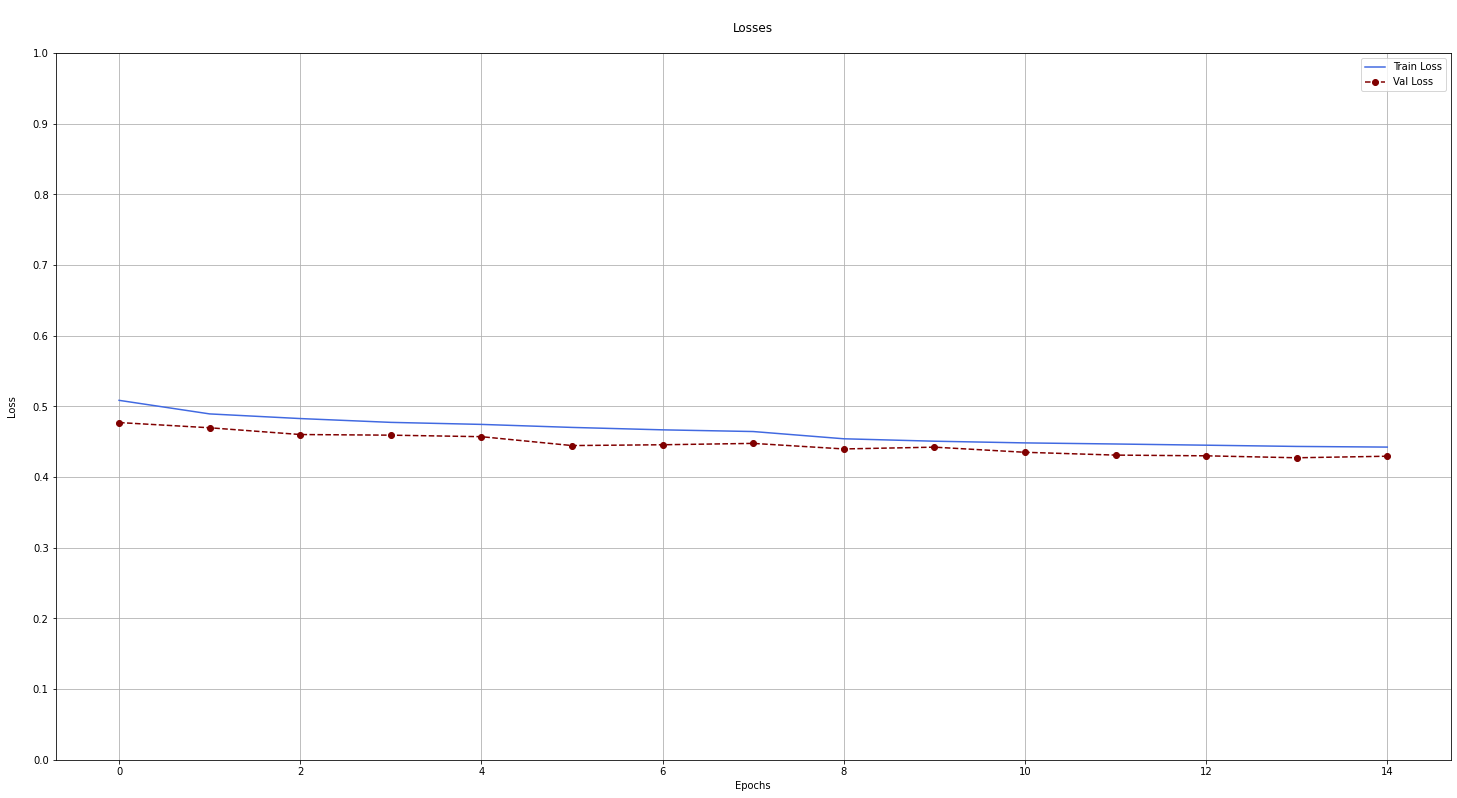

In [12]:
# plot the Training and Validation Losses
plot_metrics(metrics['train_losses'], metrics['val_losses'], 'Train Loss',
             'Val Loss', 'Loss\n', '\nLosses\n')

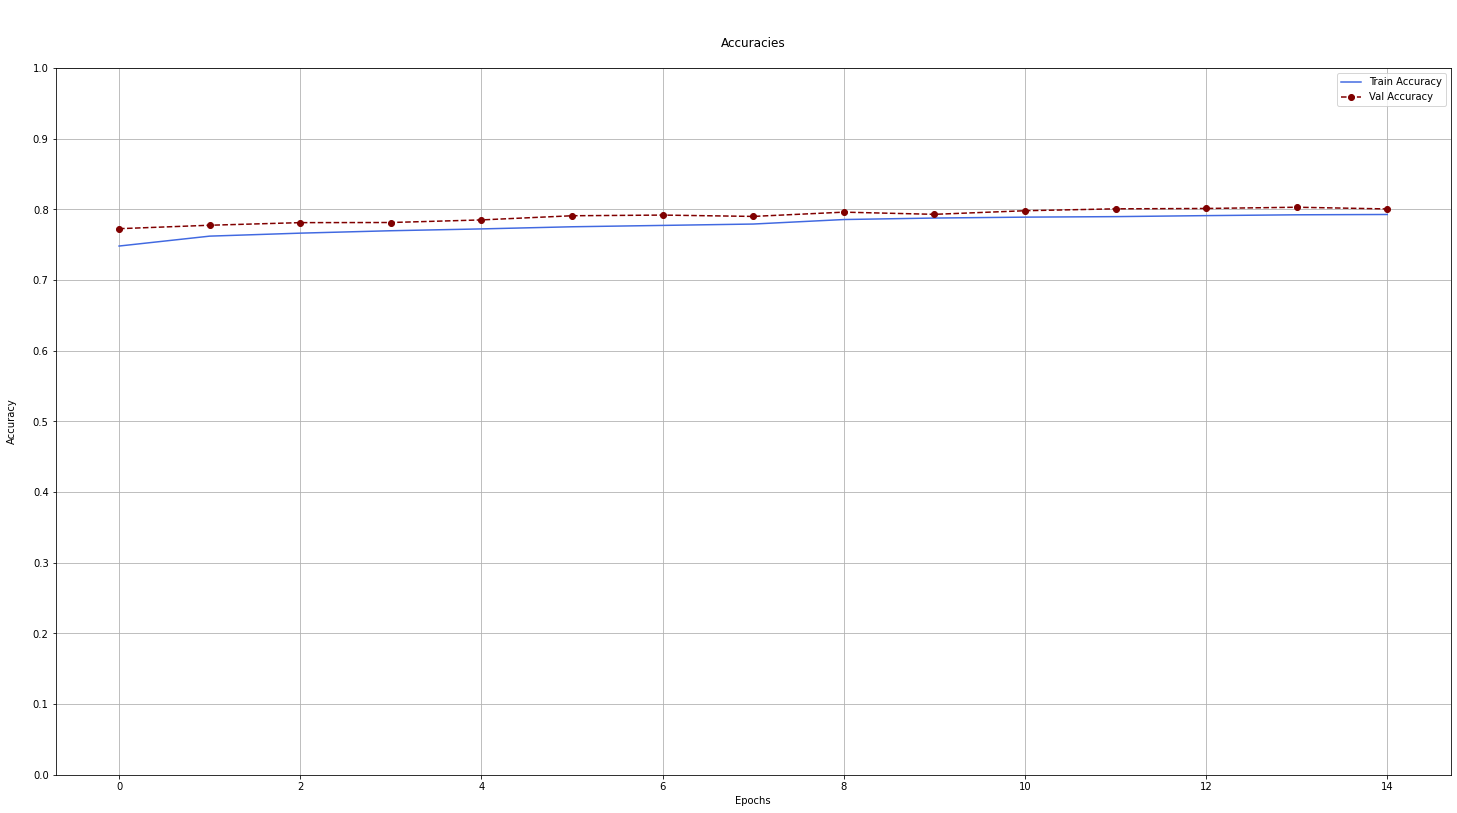

In [13]:
# plot the Training and Validation Accuracies
plot_metrics(metrics['train_accuracies'], metrics['val_accuracies'],
             'Train Accuracy', 'Val Accuracy', 'Accuracy\n', '\n\nAccuracies\n')

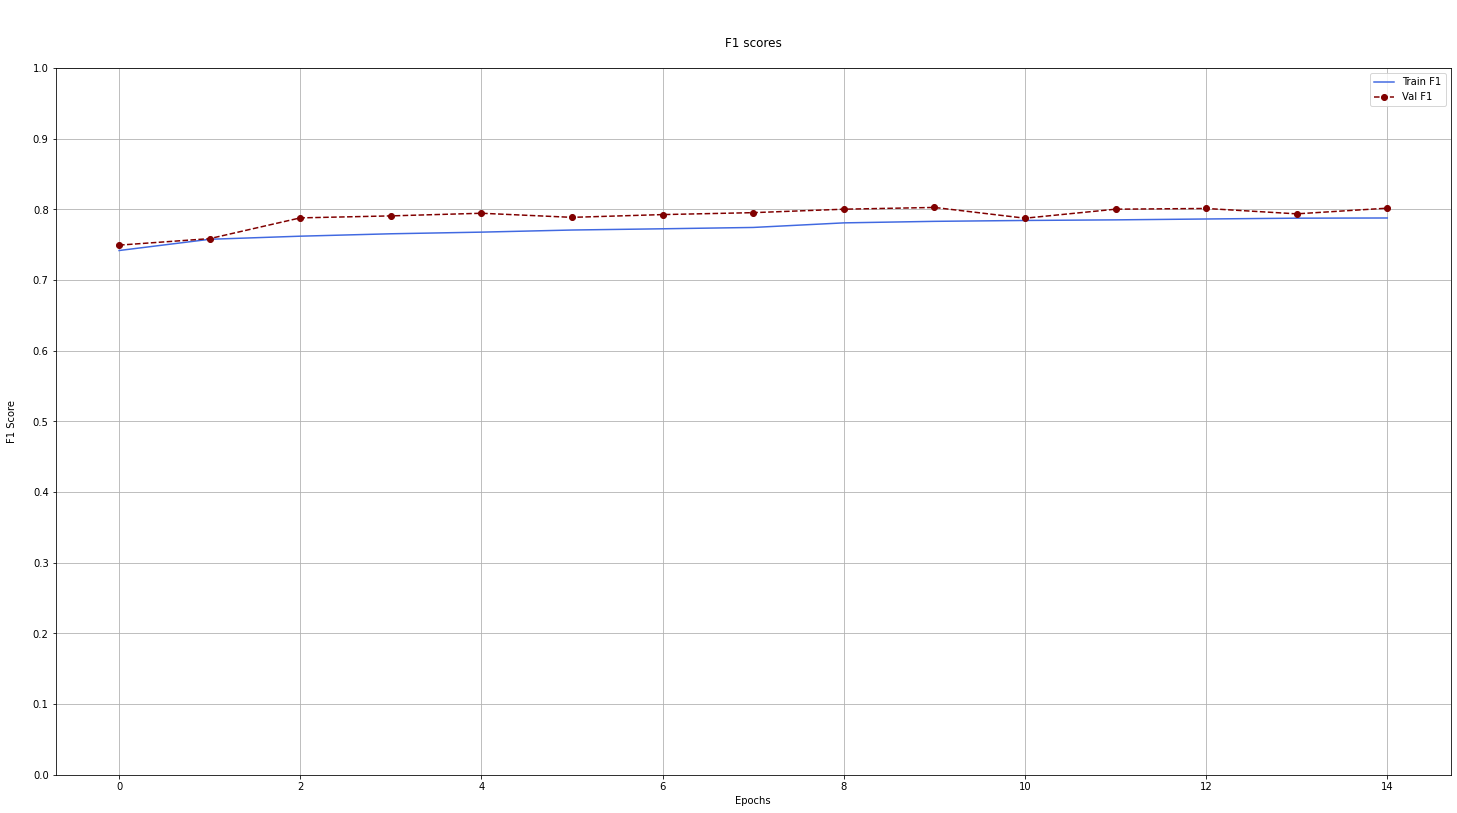

In [14]:
# plot the Training and Validation F1 scores
plot_metrics(metrics['train_f1'], metrics['val_f1'], 'Train F1', 'Val F1',
             'F1 Score\n', '\n\nF1 scores\n')

## Get the ground truths and the predictions for the whole Test Dataset

In [15]:
# function located in dataset.py
y_test, y_test_pred = get_truths_and_predictions(attention_classifier, test_iterator)

In [16]:
y_test_pred

tensor([[0.8128],
        [0.1079],
        [0.3813],
        ...,
        [0.1936],
        [0.9567],
        [0.7701]], device='cuda:0')

## Classification report and Confusion Matrix

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

threshold = 0.5
predicted_test_labels = torch.where(y_test_pred > threshold, 1, 0)

print("Classification Report:")
print(f"{classification_report(y_test.cpu(), predicted_test_labels.cpu())}")
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test.cpu(), predicted_test_labels.cpu()))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79     31906
         1.0       0.78      0.84      0.81     31972

    accuracy                           0.80     63878
   macro avg       0.80      0.80      0.80     63878
weighted avg       0.80      0.80      0.80     63878


Confusion Matrix:

[[24228  7678]
 [ 5175 26797]]


## Let's also plot the ROC Curve

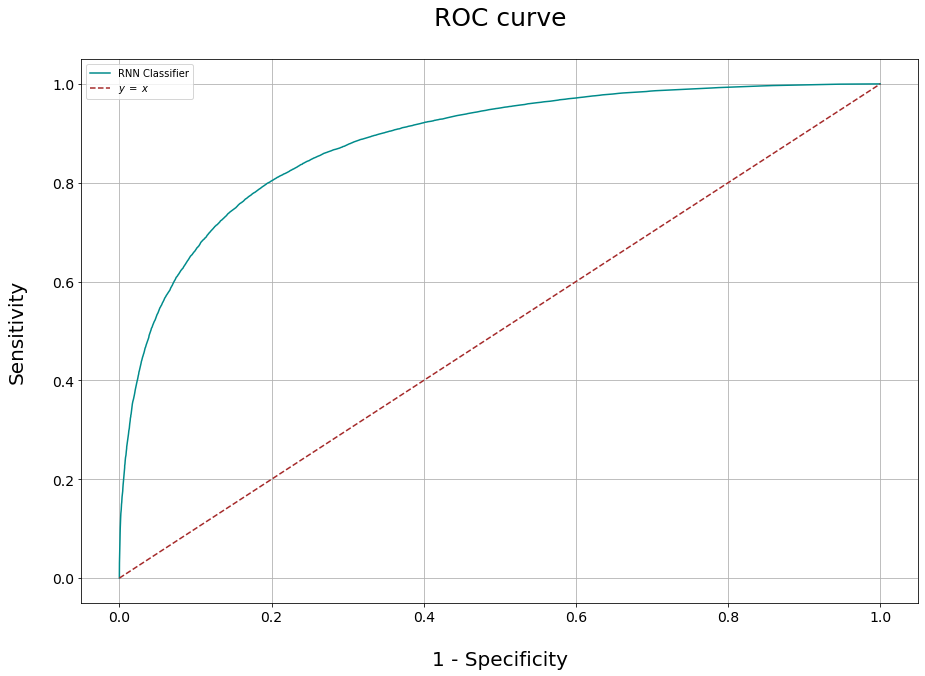

In [18]:
plot_roc_curve(y_test, y_test_pred)